# Implementations and visualizations of MCMC algoorithms

## Bayesian linear regression via Gibbs sampler

### Overview & Objective

- **Goal:** Estimate the regression parameters $\beta$ and noise variance $\sigma^2$ in the linear model  
  $$
  y = X\beta + \epsilon,\quad \epsilon \sim \mathcal{N}(0, \sigma^2 I)
  $$
- **Bayesian Setup:**  
  - Prior on $\beta$ (e.g, $\beta \sim \mathcal{N}(\mu_0, \Sigma_0)$).  
  - Prior on $\sigma^2$ (e.g, $\sigma^2 \sim \text{Inv-Gamma}(\alpha_0, \beta_0)$).  
- **Gibbs Sampling:** Alternately sample from the conditional posterior distributions for $\beta$ (a multivariate normal) and for $\sigma^2$ (an inverse-gamma).

### Code Walkthrough

1. **Data Generation and Prior Specification:**  
   - Create synthetic data with a known $\beta$ and noise level.
   - Set up the prior hyperparameters.

2. **Gibbs Sampling Loop:**  
   - Compute the conditional posterior for $\beta$:  
     $$
     V_\beta = \Big(\Sigma_0^{-1} + \frac{X^\top X}{\sigma^2}\Big)^{-1}, \quad m_\beta = V_\beta\Big(\Sigma_0^{-1}\mu_0 + \frac{X^\top y}{\sigma^2}\Big)
     $$
   - Sample $\beta$ from the multivariate normal and update $\sigma^2$ from the inverse-gamma distribution.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import invgamma, multivariate_normal

In [2]:
# Generate synthetic data
np.random.seed(42)
n, d = 100, 2
X = np.hstack((np.ones((n,1)), np.random.randn(n, d-1)))
true_beta = np.array([1.0, 2.0])
sigma_true = 1.0
y = X @ true_beta + sigma_true * np.random.randn(n)

# Prior hyperparameters
beta_prior_mean = np.zeros(d)
beta_prior_cov = np.eye(d) * 10
alpha_prior = 2.0
beta_prior_val = 1.0

# Number of iterations for Gibbs sampling
iterations = 5000
beta_samples = np.zeros((iterations, d))
sigma2_samples = np.zeros(iterations)

# Initial values
beta_current = np.zeros(d)
sigma2_current = 1.0

In [3]:
for i in range(iterations):
    # Sample beta | sigma^2, y, X
    V_beta = np.linalg.inv(np.linalg.inv(beta_prior_cov) + (X.T @ X) / sigma2_current)
    m_beta = V_beta @ (np.linalg.inv(beta_prior_cov) @ beta_prior_mean + (X.T @ y) / sigma2_current)
    beta_current = multivariate_normal.rvs(mean=m_beta, cov=V_beta)

    # Sample sigma^2 | beta, y, X
    alpha_post = alpha_prior + n/2
    residuals = y - X @ beta_current
    beta_post = beta_prior_val + 0.5 * np.sum(residuals**2)
    sigma2_current = invgamma.rvs(a=alpha_post, scale=beta_post)

    beta_samples[i, :] = beta_current
    sigma2_samples[i] = sigma2_current

Text(0, 0.5, 'β[1]')

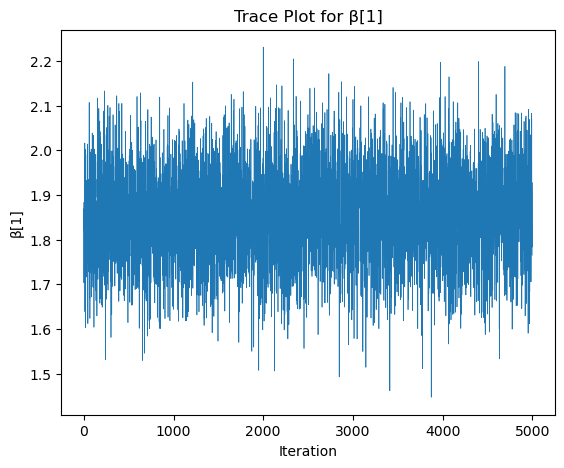

In [4]:
# Visualizations: trace plots and posterior histograms
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(beta_samples[:, 1], lw=0.5)
plt.title("Trace Plot for β[1]")
plt.xlabel("Iteration")
plt.ylabel("β[1]")

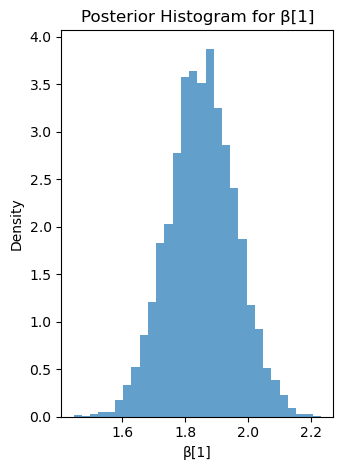

In [5]:
plt.subplot(1,2,2)
plt.hist(beta_samples[:, 1], bins=30, density=True, alpha=0.7)
plt.title("Posterior Histogram for β[1]")
plt.xlabel("β[1]")
plt.ylabel("Density")
plt.tight_layout()
plt.show()

## Audio Signal Reconstruction via Metropolis–Hastings (MH)

### Overview & Objective

- **Goal:** Reconstruct a clean audio signal $s(t)$ from a noisy observation $y(t)$.
- **Approach:**  
  - **Preprocessing:** Apply a low-pass Butterworth filter to remove high-frequency noise.  
  - **MH Sampling:** Use a proposal that perturbs the signal and accept/reject proposals based on a target distribution that is the product of:  
    - A likelihood term (ensuring the reconstructed signal is close to the observed data).
    - A smoothness prior (penalizing rapid changes in the signal).

### Code Walkthrough

1. **Synthetic Signal Generation:**  
   - Generate a sine wave as the true signal and add Gaussian noise.

2. **Preprocessing with Butterworth Filter:**  
   - Apply the filter to get a smoother starting point.

3. **MH Sampling:**  
   - Define the likelihood function (based on squared error) and the smoothness prior.
   - In each iteration, propose a new signal, compute the acceptance probability, and decide whether to accept the new proposal.

In [6]:
from scipy.signal import butter, filtfilt

In [7]:
# Generate synthetic audio: sine wave with noise
np.random.seed(42)
t = np.linspace(0, 1, 500)
s_true = np.sin(2 * np.pi * 5 * t)
noise_std = 0.3
y_noisy = s_true + noise_std * np.random.randn(len(t))

# --- Preprocessing ---
# Apply a low-pass Butterworth filter to remove high-frequency noise
def butter_lowpass_filter(data, cutoff, fs, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y_filtered = filtfilt(b, a, data)
    return y_filtered

fs = 500  # Sampling frequency (Hz)
cutoff = 10  # Cutoff frequency (Hz)
y_filtered = butter_lowpass_filter(y_noisy, cutoff, fs)

In [8]:
# --- Metropolis–Hastings for Signal Reconstruction ---
def likelihood(s, y, sigma):
    return np.exp(-0.5 * np.sum((y - s)**2) / sigma**2)

def smoothness_prior(s, lambda_reg=100):
    diff = np.diff(s)
    return np.exp(-lambda_reg * np.sum(diff**2))

def target(s, y, sigma, lambda_reg=100):
    return likelihood(s, y, sigma) * smoothness_prior(s, lambda_reg)

def mh_audio_reconstruction(y, sigma_noise, iterations=3000, proposal_std=0.05):
    s_current = y.copy()  # Initialize with the preprocessed signal
    samples = []
    for i in range(iterations):
        s_proposal = s_current + np.random.normal(0, proposal_std, size=s_current.shape)
        ratio = target(s_proposal, y, sigma_noise) / target(s_current, y, sigma_noise)
        if np.random.rand() < min(1, ratio):
            s_current = s_proposal
        samples.append(s_current.copy())
    return np.array(samples)


In [9]:
# Run MH sampler on the preprocessed (filtered) signal
iterations = 3000
samples = mh_audio_reconstruction(y_filtered, sigma_noise=noise_std, iterations=iterations)
s_reconstructed = samples[-1]

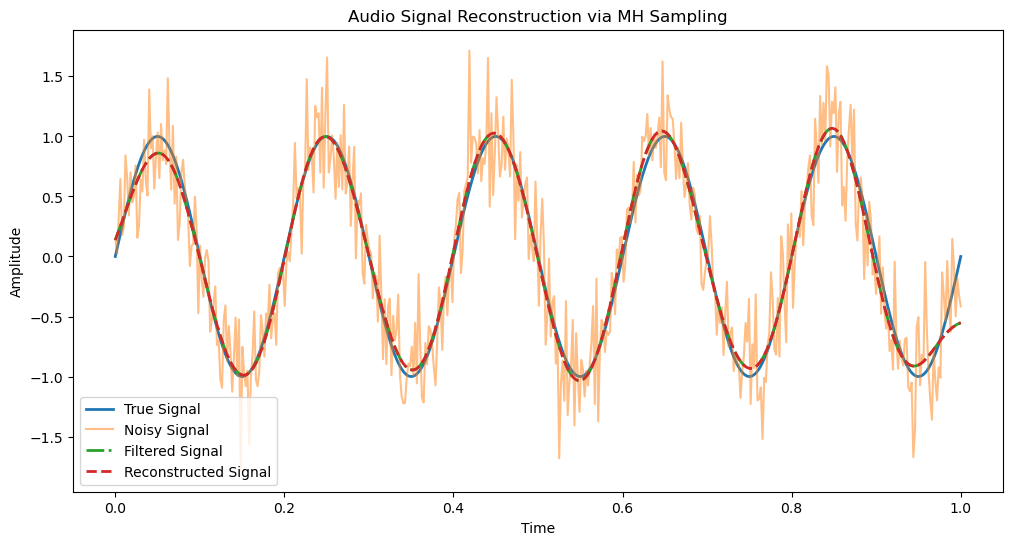

In [10]:
# Visualizations: Plot true, noisy, filtered, and reconstructed signals
plt.figure(figsize=(12,6))
plt.plot(t, s_true, label='True Signal', linewidth=2)
plt.plot(t, y_noisy, label='Noisy Signal', alpha=0.5)
plt.plot(t, y_filtered, label='Filtered Signal', linestyle='-.', linewidth=2)
plt.plot(t, s_reconstructed, label='Reconstructed Signal', linestyle='--', linewidth=2)
plt.title("Audio Signal Reconstruction via MH Sampling")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

## Image Reconstruction with Hamiltonian Monte Carlo (HMC)

### Overview & Objective

- **Goal:** Reconstruct an image from a noisy observation using HMC.
- **Approach:**  
  - **Target Distribution:** Combines a data fidelity term (to match the noisy image) and a smoothness prior (penalizing abrupt pixel changes).  
  - **HMC Mechanics:**  
    - Augment the image \(I\) with a momentum variable.
    - Use the leapfrog integrator to propose new states.
    - Accept or reject proposals based on the Hamiltonian (energy) difference.

### Code Walkthrough

1. **Synthetic Image Generation:**  
   - Create a gradient image and add noise.
2. **Defining the Energy (Log-Target) Function:**  
   - Calculate a fidelity term: $-\frac{1}{2\sigma^2}\|Y-I\|^2$.
   - Calculate a smoothness term using finite differences.  
     *Note:* Make sure the gradient of the smoothness term is computed with the correct sign.
3. **HMC Update Function:**  
   - Implement the leapfrog integrator.
   - Reverse the momentum for symmetry.
   - Calculate Hamiltonians before and after the update.
4. **Running the Sampler and Visualization:**  
   - Run for several iterations, compute and print the acceptance rate.
   - Plot the true image, the noisy image, and the reconstructed image.

In [11]:
from scipy.ndimage import gaussian_filter

In [12]:
# Create synthetic image: gradient image with noise
np.random.seed(42)
image_size = 64
true_image = np.outer(np.linspace(0, 1, image_size), np.linspace(0, 1, image_size))
noisy_image = true_image + 0.3 * np.random.randn(image_size, image_size)

# Define the target log-probability (negative energy) for the image.
# Combines a data fidelity term with a smoothness prior.
def log_target(I, Y, sigma, lambda_reg):
    fidelity = -0.5 * np.sum((Y - I)**2) / sigma**2
    # Smoothness via a quadratic penalty on finite differences
    smoothness = -lambda_reg * (np.sum(np.diff(I, axis=0)**2) + np.sum(np.diff(I, axis=1)**2))
    return fidelity + smoothness

# HMC parameters
step_size = 0.001
num_steps = 20
iterations = 100
sigma_noise = 0.3
lambda_reg = 0.1


In [13]:
# Initialize with the noisy image
I_current = noisy_image.copy()

def hmc_update(I_current, Y, step_size, num_steps, sigma, lambda_reg):
    I = I_current.copy()
    momentum = np.random.randn(*I.shape)
    current_momentum = momentum.copy()

    # Compute gradient of log_target using finite differences (central differences)
    def grad_log_target(I):
        grad = np.zeros_like(I)
        # Fidelity term gradient
        grad += (Y - I) / sigma**2
        # Smoothness gradient (using differences)
        grad[:-1, :] += 2 * lambda_reg * (I[:-1, :] - I[1:, :])
        grad[1:, :]  -= 2 * lambda_reg * (I[:-1, :] - I[1:, :])
        grad[:, :-1] += 2 * lambda_reg * (I[:, :-1] - I[:, 1:])
        grad[:, 1:]  -= 2 * lambda_reg * (I[:, :-1] - I[:, 1:])
        return grad

    # Leapfrog integration
    grad = grad_log_target(I)
    momentum += 0.5 * step_size * grad
    for _ in range(num_steps):
        I += step_size * momentum
        grad = grad_log_target(I)
        momentum += step_size * grad
    momentum += 0.5 * step_size * grad
    # Negate momentum for symmetry
    momentum = -momentum

    # Compute Hamiltonians
    current_H = -log_target(I_current, Y, sigma, lambda_reg) + 0.5 * np.sum(current_momentum**2)
    proposed_H = -log_target(I, Y, sigma, lambda_reg) + 0.5 * np.sum(momentum**2)
    if np.random.rand() < np.exp(current_H - proposed_H):
        return I, True
    else:
        return I_current, False


In [14]:
hmc_images = []
accepted = 0
for it in range(iterations):
    I_new, acc = hmc_update(I_current, noisy_image, step_size, num_steps, sigma_noise, lambda_reg)
    if acc:
        accepted += 1
    I_current = I_new
    hmc_images.append(I_current.copy())

print(f"HMC Acceptance Rate: {accepted/iterations:.3f}")

HMC Acceptance Rate: 0.710


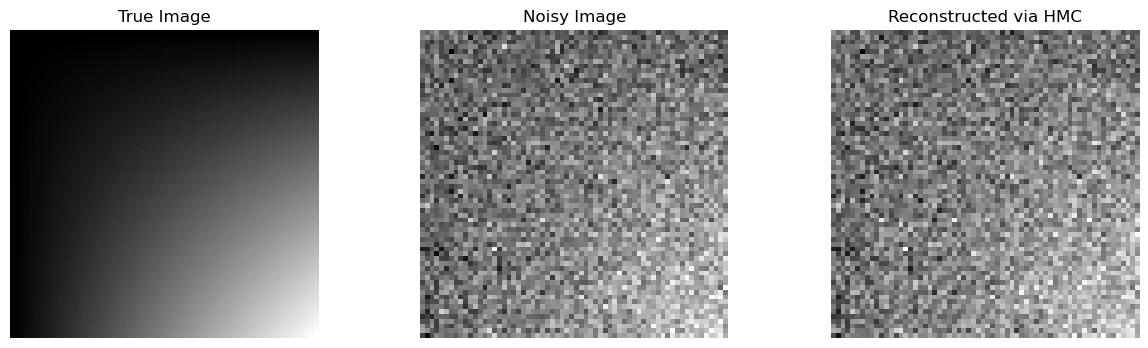

In [15]:
# Visualizations: Compare true, noisy, and reconstructed images
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.imshow(true_image, cmap='gray')
plt.title("True Image")
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(noisy_image, cmap='gray')
plt.title("Noisy Image")
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(hmc_images[-1], cmap='gray')
plt.title("Reconstructed via HMC")
plt.axis('off')
plt.show()

## Implicit Neural Representations (Neural SDF) with MALA


### Overview & Objective

- **Goal:** Sample the latent space of a Neural Signed Distance Function (SDF) model using the Metropolis Adjusted Langevin Algorithm (MALA).
- **Approach:**  
  - **Neural SDF:** A neural network that takes a 3D point and a latent vector to produce a signed distance value.
  - **MALA:** Incorporates gradient information from the log-posterior (combining the log-likelihood and log-prior) to propose updates for the latent vector.
  - **Uncertainty Estimation:** Helps capture uncertainty in the implicit representation.

### Code Walkthrough

1. **Model Definition:**  
   - Define a simple PyTorch neural network with a latent parameter.
2. **Simulated Observations:**  
   - Generate synthetic SDF observations around a sphere.
3. **Log-Posterior Definition:**  
   - Define the log-likelihood (based on the difference between observed and predicted SDF values) and a log-prior (standard normal prior on the latent).
4. **MALA Update:**  
   - Compute gradients using PyTorch autograd.
   - Update the latent vector using the MALA proposal rule.
   - Use an acceptance criterion based on the change in log-posterior.

In [16]:
import torch
import torch.nn as nn

In [17]:
# Define a simple Neural SDF with a latent vector parameter
class NeuralSDF(nn.Module):
    def __init__(self, latent_dim=5):
        super(NeuralSDF, self).__init__()
        self.latent = nn.Parameter(torch.randn(latent_dim))
        self.fc = nn.Sequential(
            nn.Linear(3 + latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        # x: [batch, 3]
        latent_expand = self.latent.unsqueeze(0).expand(x.size(0), -1)
        x_input = torch.cat([x, latent_expand], dim=1)
        return self.fc(x_input)

In [18]:
# Generate simulated observations: points near a sphere of radius 0.8
def generate_sdf_observations(n_points=200):
    points = torch.rand(n_points, 3) * 2 - 1  # uniformly in [-1,1]^3
    sdf_true = torch.norm(points, dim=1, keepdim=True) - 0.8
    sdf_obs = sdf_true + 0.05 * torch.randn_like(sdf_true)
    return points, sdf_obs

points, sdf_obs = generate_sdf_observations(200)

# Define log-likelihood and log-prior for the latent variable
def log_likelihood(model, points, sdf_obs, sigma=0.05):
    pred = model(points)
    return -0.5 * torch.sum((sdf_obs - pred)**2) / sigma**2

def log_prior(model):
    return -0.5 * torch.sum(model.latent**2)

def log_posterior(model, points, sdf_obs, sigma=0.05):
    return log_likelihood(model, points, sdf_obs, sigma) + log_prior(model)

In [19]:
# MALA update for the latent variable
def mala_update(model, points, sdf_obs, sigma=0.05, step_size=1e-3):
    model.zero_grad()
    logp = log_posterior(model, points, sdf_obs, sigma)
    logp.backward()
    grad = model.latent.grad.detach()
    latent_current = model.latent.detach().clone()
    noise = torch.randn_like(latent_current)
    latent_proposal = latent_current + 0.5 * step_size * grad + torch.sqrt(torch.tensor(step_size)) * noise

    # Compute acceptance probability (using symmetric proposal assumption)
    latent_old = model.latent.data.clone()
    model.latent.data = latent_proposal
    logp_proposal = log_posterior(model, points, sdf_obs, sigma)
    accept_prob = torch.exp(logp_proposal - logp)
    if torch.rand(1) < accept_prob:
        accepted = True
    else:
        model.latent.data = latent_old
        accepted = False
    return accepted, model.latent.data.clone(), logp_proposal.item()

In [20]:
model = NeuralSDF(latent_dim=5)
iterations = 2000
latent_samples = []
log_probs = []
accepts = 0

for i in range(iterations):
    accepted, latent_sample, lp = mala_update(model, points, sdf_obs, sigma=0.05, step_size=1e-3)
    latent_samples.append(latent_sample.numpy())
    log_probs.append(lp)
    if accepted:
        accepts += 1

print(f"MALA Acceptance Rate: {accepts/iterations:.3f}")

MALA Acceptance Rate: 0.636


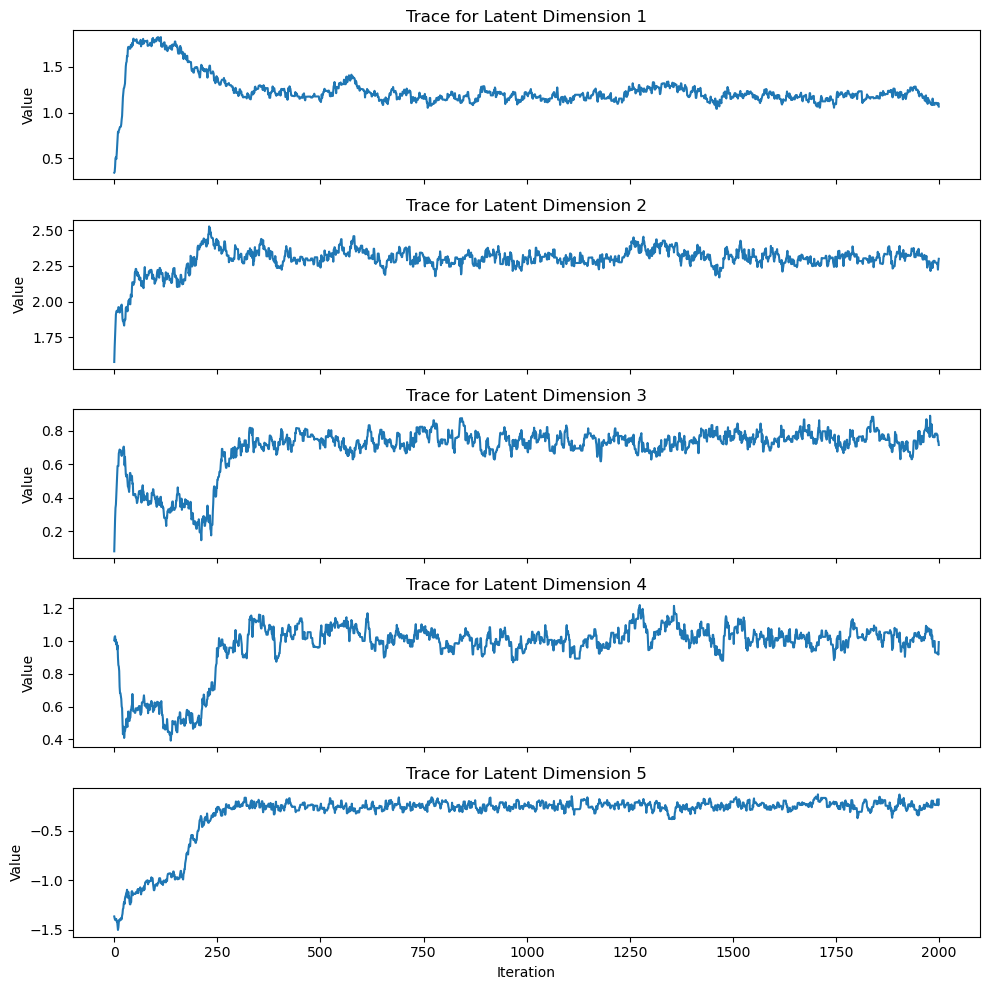

In [21]:
# Improved Visualization: Plot traces for each latent dimension
latent_samples = np.array(latent_samples)
fig, axs = plt.subplots(model.latent.shape[0], 1, figsize=(10, 2*model.latent.shape[0]), sharex=True)
for i in range(model.latent.shape[0]):
    axs[i].plot(latent_samples[:, i])
    axs[i].set_title(f"Trace for Latent Dimension {i+1}")
    axs[i].set_ylabel("Value")
axs[-1].set_xlabel("Iteration")
plt.tight_layout()
plt.show()